In [1]:
 !pip install chromadb --quiet

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from sentence_transformers import SentenceTransformer

model_id = "all-MiniLM-L6-v2"
model = SentenceTransformer("all-MiniLM-L6-v2").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Data/ Vector Store

In [4]:
physics = [
    "Albert Einstein formulated the theory of relativity in the early 20th century.",
    "Newton's laws of motion revolutionized our understanding of physics in the 17th century.",
    "Quantum mechanics was developed by physicists like Heisenberg and Schrödinger in the 1920s.",
    "Einstein's famous equation E=mc² demonstrates the equivalence of mass and energy.",
    "The photoelectric effect discovery earned Einstein the Nobel Prize in Physics in 1921.",
    "Niels Bohr proposed the atomic model that explained electron behavior around the nucleus.",
    "Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.",
    "The uncertainty principle states that position and momentum cannot be measured simultaneously.",
    "General relativity predicts that massive objects bend spacetime around them.",
    "Marie Curie conducted pioneering research on radioactivity and discovered polonium and radium.",
    "The double-slit experiment demonstrates the wave-particle duality of light and matter.",
]

biology = [
    "Charles Darwin published his theory of evolution by natural selection in 1859.",
    "DNA contains the genetic instructions for all living organisms on Earth.",
    "Gregor Mendel discovered the fundamental laws of inheritance through pea plant experiments.",
    "The cell theory states that all living things are composed of one or more cells.",
    "Photosynthesis allows plants to convert sunlight into chemical energy for growth.",
    "Watson and Crick determined the double helix structure of DNA in 1953.",
    "Mitosis is the process by which cells divide to create identical daughter cells.",
    "The human genome contains approximately 3 billion DNA base pairs across 23 chromosomes.",
    "Evolution explains the diversity of life through gradual changes over millions of years.",
    "Enzymes are biological catalysts that speed up chemical reactions in living organisms.",
]

history = [
    "The Neolithic Revolution occurred around 10,000–8,000 BCE in the Fertile Crescent.",
    "Cuneiform writing emerged in ancient Mesopotamia by the late 4th millennium BCE.",
    "Classical Athens advanced democratic institutions in the 5th century BCE.",
    "The Roman Empire reached its greatest extent under Trajan around 117 CE.",
    "The Islamic Golden Age spanned roughly the 8th to 13th centuries.",
    "The Mongol Empire unified vast parts of Eurasia in the 13th century.",
    "The Renaissance revitalized art, science, and humanism from the 14th to 17th centuries.",
    "The American Revolution (1776) and French Revolution (1789) reshaped politics.",
    "The Industrial Revolution mechanized production in the late 18th and 19th centuries.",
    "World War II ended in 1945, reshaping the international order.",
]

technology = [
    "Movable-type printing emerged in Europe in the mid-15th century.",
    "The steam engine catalyzed industrialization in the 18th century.",
    "Telegraph networks enabled rapid long-distance communication in the 19th century.",
    "Electrification transformed cities and industry in the late 19th century.",
    "Internal combustion engines powered cars and planes in the early 20th century.",
    "The transistor, invented in 1947, enabled modern electronics.",
    "ARPANET launched in 1969 as a precursor to the Internet.",
    "The World Wide Web spread globally in the 1990s.",
    "Genome sequencing advances accelerated biotech in the 2000s.",
    "Machine learning advances expanded AI applications in the 2010s–2020s.",
]

physics = [{"text": d, "label": "Physics"} for d in physics]
biology = [{"text": d, "label": "Biology"} for d in biology]
history = [{"text": d, "label": "History"} for d in history]
technology = [{"text": d, "label": "Technology"} for d in technology]

documents = physics + biology + history + technology

In [5]:
import chromadb

collection_name = "xai"
client = chromadb.Client()
metric = "cosine"
collection = client.get_or_create_collection(
    name=collection_name,
    configuration={
        "hnsw": {
            "space": metric,
            "ef_construction": 200
        }
    }
)

In [6]:
doc_embeddings = model.encode([d["text"] for d in documents], normalize_embeddings=True).tolist()

documents = [{"vector": v} | d for d, v in zip(documents, doc_embeddings)]

collection.add(
    ids=[str(i) for i in range(len(doc_embeddings))],
    documents=[d["text"] for d in documents],
    embeddings=doc_embeddings,
    metadatas=[{"label": d["label"]} for d in documents]
)

In [7]:
query = "famous physicists and their contributions"

query_embedding = model.encode(query, normalize_embeddings=True).tolist()
res = collection.query(query_embedding, n_results=10, include=["embeddings", "documents", "distances", "metadatas"])
res

{'ids': [['6', '2', '4', '1', '0', '3', '9', '11', '13', '10']],
 'embeddings': [array([[-4.14007790e-02,  2.16717627e-02, -1.08505844e-03, ...,
          -4.46190611e-02,  2.61495472e-03,  1.40560716e-02],
         [-1.15475934e-02,  1.69467758e-02, -6.23083264e-02, ...,
           1.99484546e-02,  1.69039872e-02,  6.13281839e-02],
         [-9.31872427e-02,  1.00586861e-01, -3.00539061e-02, ...,
          -4.78571020e-02, -6.92625046e-02,  2.25894805e-02],
         ...,
         [-5.07243238e-02,  5.53676449e-02,  1.19442130e-02, ...,
           6.23587705e-02,  3.17521468e-02,  5.55558540e-02],
         [-7.50079751e-02,  4.24699970e-02,  1.42873917e-02, ...,
           1.44666722e-02,  7.30443522e-02, -5.70261254e-05],
         [-7.11106881e-02, -3.79753858e-02,  6.27442170e-03, ...,
           2.14042850e-02,  4.78801876e-03,  2.19497830e-02]])],
 'documents': [['Stephen Hawking studied black holes and made groundbreaking contributions to cosmology.',
   'Quantum mechanics was dev

In [8]:
def unpack_results(results: dict) -> list[dict]:
    combined = list()
    combined = [{"document": doc, "score": score, "label": meta["label"], "vector": vec} for doc, score, meta, vec in zip(results["documents"][0], results["distances"][0], results["metadatas"][0], results["embeddings"][0])]
    if metric == "cosine" or metric == "ip":
        # Highest score (similarity) on top
        return sorted(combined, key=lambda x: x["score"], reverse=True)
    else:
        # Lowest score (distance) on top
        return sorted(combined, key=lambda x: x["score"], reverse=False)

# Direct Token Importance (Between Query and Documents)

In [9]:
import numpy as np
from sentence_transformers import util

In [10]:
def mean_pooling(token_embeddings, attention_mask):
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    return (token_embeddings * mask_expanded).sum(0) / mask_expanded.sum(0)

In [11]:
def build_leave_out_token_subset(text: str) -> list[dict[str, str]]:
    # Direkt mit tokenizer.tokenize arbeiten; Achtung: nicht verlustfrei
    toks = model.tokenizer.tokenize(text)
    subsets = []
    for i, tok in enumerate(toks):
        # entferne exakt ein Token (Leave-one-out), ohne [MASK]-Ersatz
        kept = [t for k, t in enumerate(toks) if k != i]
        removed_text = model.tokenizer.convert_tokens_to_string(kept)
        subsets.append({"text": removed_text, "token": tok})
    return subsets

In [12]:
from tqdm import tqdm

def token_importance(query, documents) -> list[dict[str, dict[str, float]]]:
    embedded_query = model.encode(query, normalize_embeddings=True) # query embedding
    document_embeddings = model.encode(documents, normalize_embeddings=True) # document embeddings

    full_similarities = util.cos_sim(embedded_query, document_embeddings).tolist()[0] # query to document similarities

    # Create Leave-out Sublists
    leave_out_docs = [build_leave_out_token_subset(doc) for doc in documents]
    leave_out_query = build_leave_out_token_subset(query)

    # Result
    token_importance: list[dict[str, dict[str, float]]] = list()

    for doc_subsets, doc_emb, full_sim in tqdm(zip(leave_out_docs, document_embeddings, full_similarities), total=len(leave_out_docs)):

        # Document Tokens -> Query
        doc_token_importance: dict[str, float] = dict()
        for item in doc_subsets:
            masked_text = item["text"]
            masked_token = item["token"]
            sub_embedding = model.encode(masked_text, normalize_embeddings=True)
            sub_sim = util.cos_sim(sub_embedding, query_embedding).item()
            doc_token_importance[masked_token] = full_sim - sub_sim

        # Query Tokens -> Document
        query_token_importance: dict[str, float] = dict()
        for item in leave_out_query:
            masked_text = item["text"]
            masked_token = item["token"]
            sub_embedding = model.encode(masked_text, normalize_embeddings=True)
            sub_sim = util.cos_sim(sub_embedding, doc_emb).item()
            query_token_importance[masked_token] = full_sim - sub_sim

        token_importance.append({
            "document": doc_token_importance,
            "query": query_token_importance
        })

    return token_importance

In [13]:
import matplotlib.pyplot as plt

def plot_influence(results, title, sharey=True):
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n), squeeze=False)

    for i, res in tqdm(enumerate(results), total=len(results), desc="Creating Plots"):
        doc_contrib = res["document"]
        qry_contrib = res["query"]

        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # Document
        ax_left.bar(list(doc_contrib.keys()), list(doc_contrib.values()), color="#4c78a8")
        ax_left.axhline(0, color="black", linewidth=0.8)
        ax_left.set_title("Document")
        ax_left.set_ylabel("Influence")
        ax_left.tick_params(axis="x", rotation=75)

        # Query
        ax_right.bar(list(qry_contrib.keys()), list(qry_contrib.values()), color="#f58518")
        ax_right.axhline(0, color="black", linewidth=0.8)
        ax_right.set_title("Query")
        ax_right.tick_params(axis="x", rotation=45)

        if sharey:
            ymin = min(min(doc_contrib.values(), default=0), min(qry_contrib.values(), default=0))
            ymax = max(max(doc_contrib.values(), default=0), max(qry_contrib.values(), default=0))
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax_left.set_ylim(ymin - pad, ymax + pad)
            ax_right.set_ylim(ymin - pad, ymax + pad)

    fig.suptitle(title, y=0.995)
    fig.tight_layout()
    return fig

Creating Plots: 100%|██████████| 10/10 [00:00<00:00, 20.21it/s]


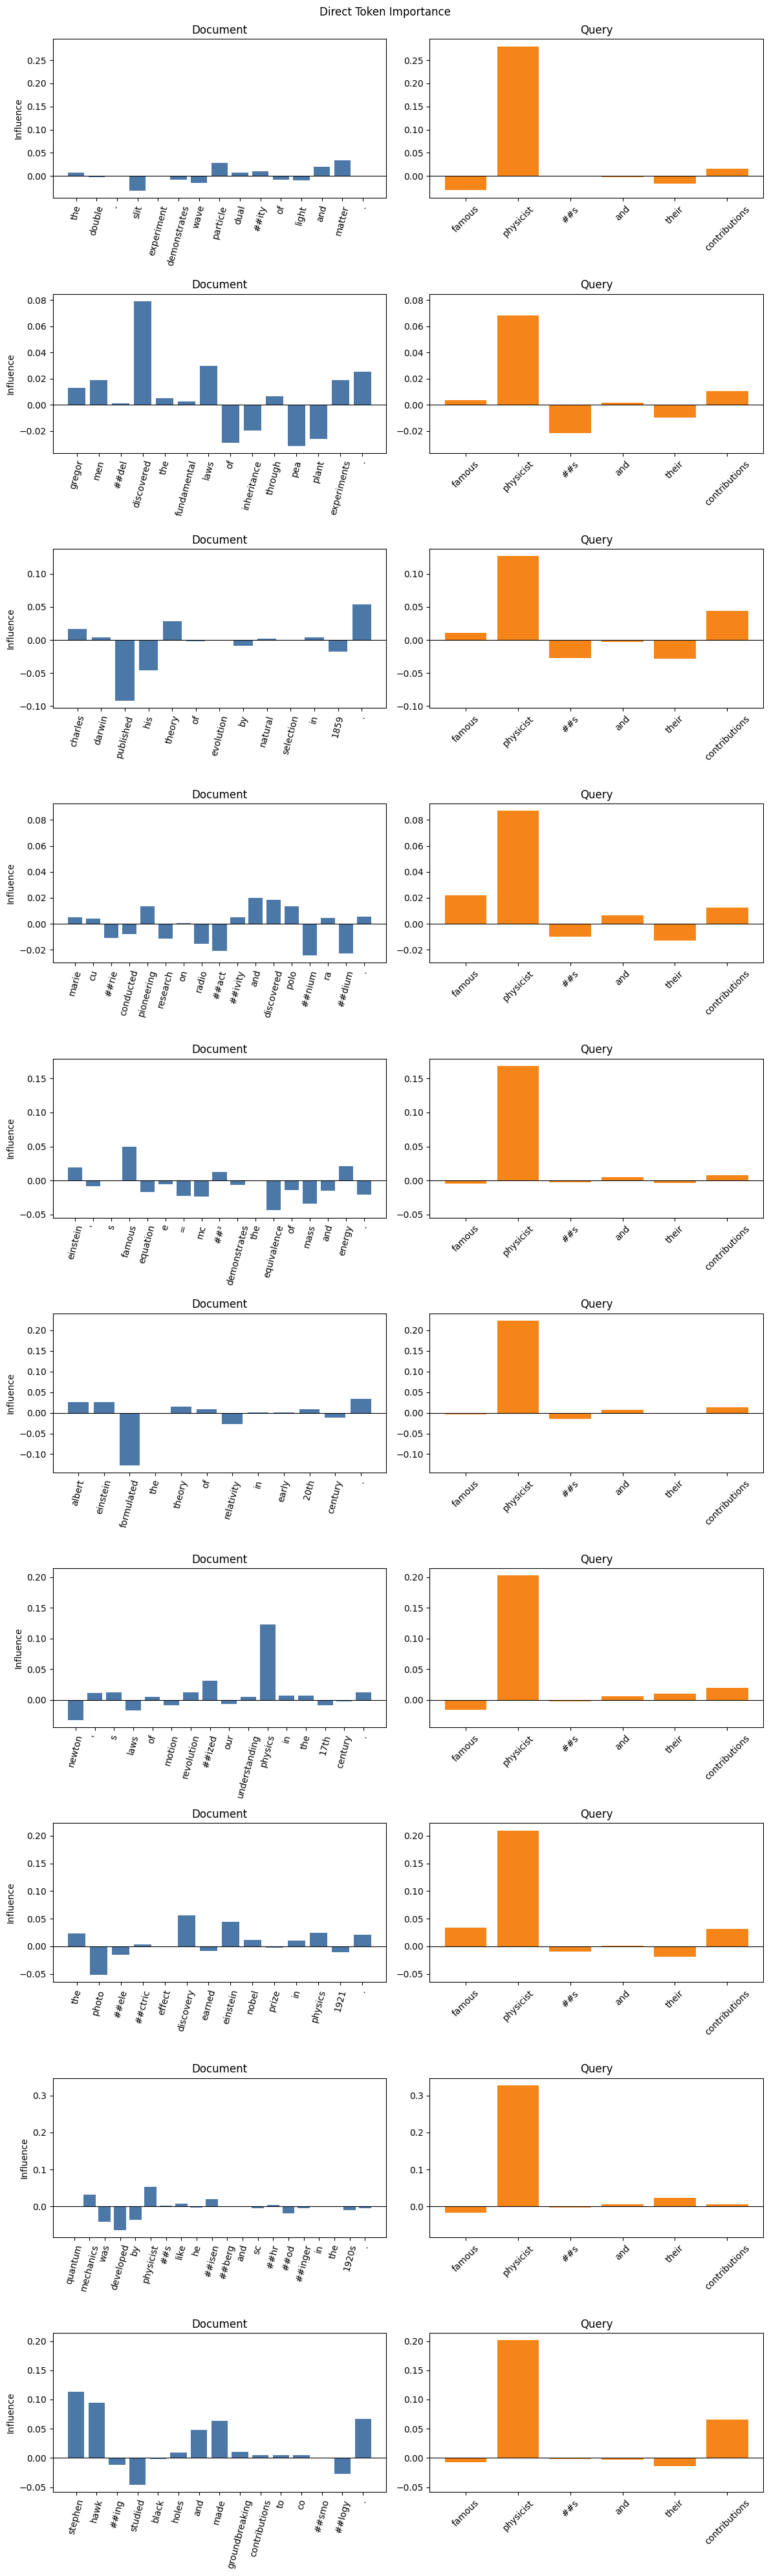

In [14]:
results = unpack_results(res)
importance = token_importance(query, [r["document"] for r in results])

figure = plot_influence(importance, "Direct Token Importance")
figure.show()

# Lime (surrogate model)

In [15]:
def core_slice(tokens: list[str]) -> slice:
    if len(tokens) >= 2:
        return slice(1, len(tokens) - 1)
    return slice(0, len(tokens))

In [16]:
def extract_core_stokens(tokens: list[str]) -> slice:
    """Returns the core Tokens Sequence. Removes start [CLS] and end [SEP] token."""
    if len(tokens) >= 2:
        return slice(1, len(tokens) - 1)
    return slice(0, len(tokens))

In [17]:
def sample_masks(n_core: int, n_samples: int, keep_prob: float = 0.8, max_flips: int = 3) -> np.ndarray:
    rng = np.random.default_rng(42)
    masks = []
    for _ in range(n_samples):
        m = (rng.random(n_core) < keep_prob).astype(np.int32)
        flips = rng.integers(low=0, high=max_flips + 1)
        if flips > 0 and n_core > 0:
            idx = rng.choice(n_core, size=min(flips, n_core), replace=False)
            m[idx] = 1 - m[idx]
        if m.sum() == 0 and n_core > 0:
            m[rng.integers(0, n_core)] = 1
        masks.append(m)
    return np.stack(masks, axis=0)

In [18]:
def hamming_distance(m1: np.ndarray, m2: np.ndarray) -> int:
    return int(np.sum(m1 != m2))

def lime_kernel(dist: float, sigma: float) -> float:
    return float(np.exp(-(dist**2) / (sigma**2)))

In [19]:
from sklearn.linear_model import LinearRegression


def lime(query: str, document: str, n_samples: int = 500, sigma: float = 1.0, keep_prob: float = 0.85, max_flips: int = 2) -> dict[str, dict[str, float]]:
    # Query
    query_encoded = model.tokenize([query]) # input_ids +  attention_mask
    query_tokens = model.tokenizer.convert_ids_to_tokens(query_encoded["input_ids"][0]) # Tokens (not ids)
    query_attention_mask = query_encoded["attention_mask"][0]
    query_token_embedding = model.encode(query, normalize=True, output_value="token_embeddings").cpu()
    query_embedding = mean_pooling(query_token_embedding, query_attention_mask)

    # Document
    doc_encoded = model.tokenize([document])
    doc_tokens = model.tokenizer.convert_ids_to_tokens(doc_encoded["input_ids"][0])
    doc_attention_mask = doc_encoded["attention_mask"][0]
    doc_token_embedding = model.encode(document, normalize=True, output_value="token_embeddings").cpu()
    doc_embedding = mean_pooling(doc_token_embedding, doc_attention_mask)

    base_score = util.cos_sim(query_embedding, doc_embedding).item()

    # Remove [CLS] and [SEP] Tokens
    query_tokens_core = extract_core_stokens(query_tokens)
    n_core_q = max(0, query_tokens_core.stop - query_tokens_core.start) # Core Query Length (All Tokens without special Tokens)
    document_tokens_core = extract_core_stokens(doc_tokens)
    n_core_d = max(0, document_tokens_core.stop - document_tokens_core.start) # Core Document Length (All Tokens without special Tokens)

    # Query Tokens -> Document
    query_maskset = sample_masks(n_core=n_core_q, n_samples=n_samples, keep_prob=keep_prob, max_flips=max_flips) # Masks for core Query sequence
    q_mask_full = np.ones(len(query_tokens), dtype=np.int32)
    X_q, y_q, w_q = [], [], []
    q_ref_core = np.ones(n_core_q, dtype=np.int32) # All 1 (normal attention_mask), used to fix

    for m_core in query_maskset:
        m_full = q_mask_full.copy()
        m_full[query_tokens_core] = m_core # Apply mask to core token sequence
        attn_mask = torch.tensor(m_full)
        q_subset_emb = mean_pooling(query_token_embedding, attn_mask)
        score = util.cos_sim(q_subset_emb, doc_embedding).item() # Masked Score
        dist = hamming_distance(m_core, q_ref_core)
        weight = lime_kernel(dist, sigma)
        X_q.append(m_core.astype(np.float32))
        y_q.append(score)
        w_q.append(weight)

    X_q = np.asarray(X_q, dtype=np.float32)
    y_q = np.asarray(y_q, dtype=np.float32)
    w_q = np.asarray(w_q, dtype=np.float32)

    reg_q = LinearRegression()
    reg_q.fit(X_q, y_q, sample_weight=w_q)
    q_coefs_core = reg_q.coef_

    # Map Coefs to Tokens
    q_token_importance = {tok: float(coef) for tok, coef in zip(query_tokens[query_tokens_core], q_coefs_core)}

    # Document Tokens -> Query
    d_masks_core = sample_masks(n_core=n_core_d, n_samples=n_samples, keep_prob=keep_prob, max_flips=max_flips) # Masks for core Document sequence
    d_mask_full = np.ones(len(doc_tokens), dtype=np.int32)
    X_d, y_d, w_d = [], [], []
    d_ref_core = np.ones(n_core_d, dtype=np.int32)

    for m_core in d_masks_core:
        m_full = d_mask_full.copy()
        m_full[document_tokens_core] = m_core
        attn_mask = torch.tensor(m_full)
        d_subset_emb = mean_pooling(doc_token_embedding, attn_mask)
        score = util.cos_sim(query_embedding, d_subset_emb).item()
        dist = hamming_distance(m_core, d_ref_core)
        weight = lime_kernel(dist, sigma)
        X_d.append(m_core.astype(np.float32))
        y_d.append(score)
        w_d.append(weight)

    X_d = np.asarray(X_d, dtype=np.float32)
    y_d = np.asarray(y_d, dtype=np.float32)
    w_d = np.asarray(w_d, dtype=np.float32)

    reg_d = LinearRegression()
    reg_d.fit(X_d, y_d, sample_weight=w_d)
    d_coefs_core = reg_d.coef_
    d_token_importance = {tok: float(coef) for tok, coef in zip(doc_tokens[document_tokens_core], d_coefs_core)}

    return {
        #"base_score": base_score,
        "query": q_token_importance,
        "document": d_token_importance,
    }

Creating Plots: 100%|██████████| 10/10 [00:00<00:00, 55.70it/s]


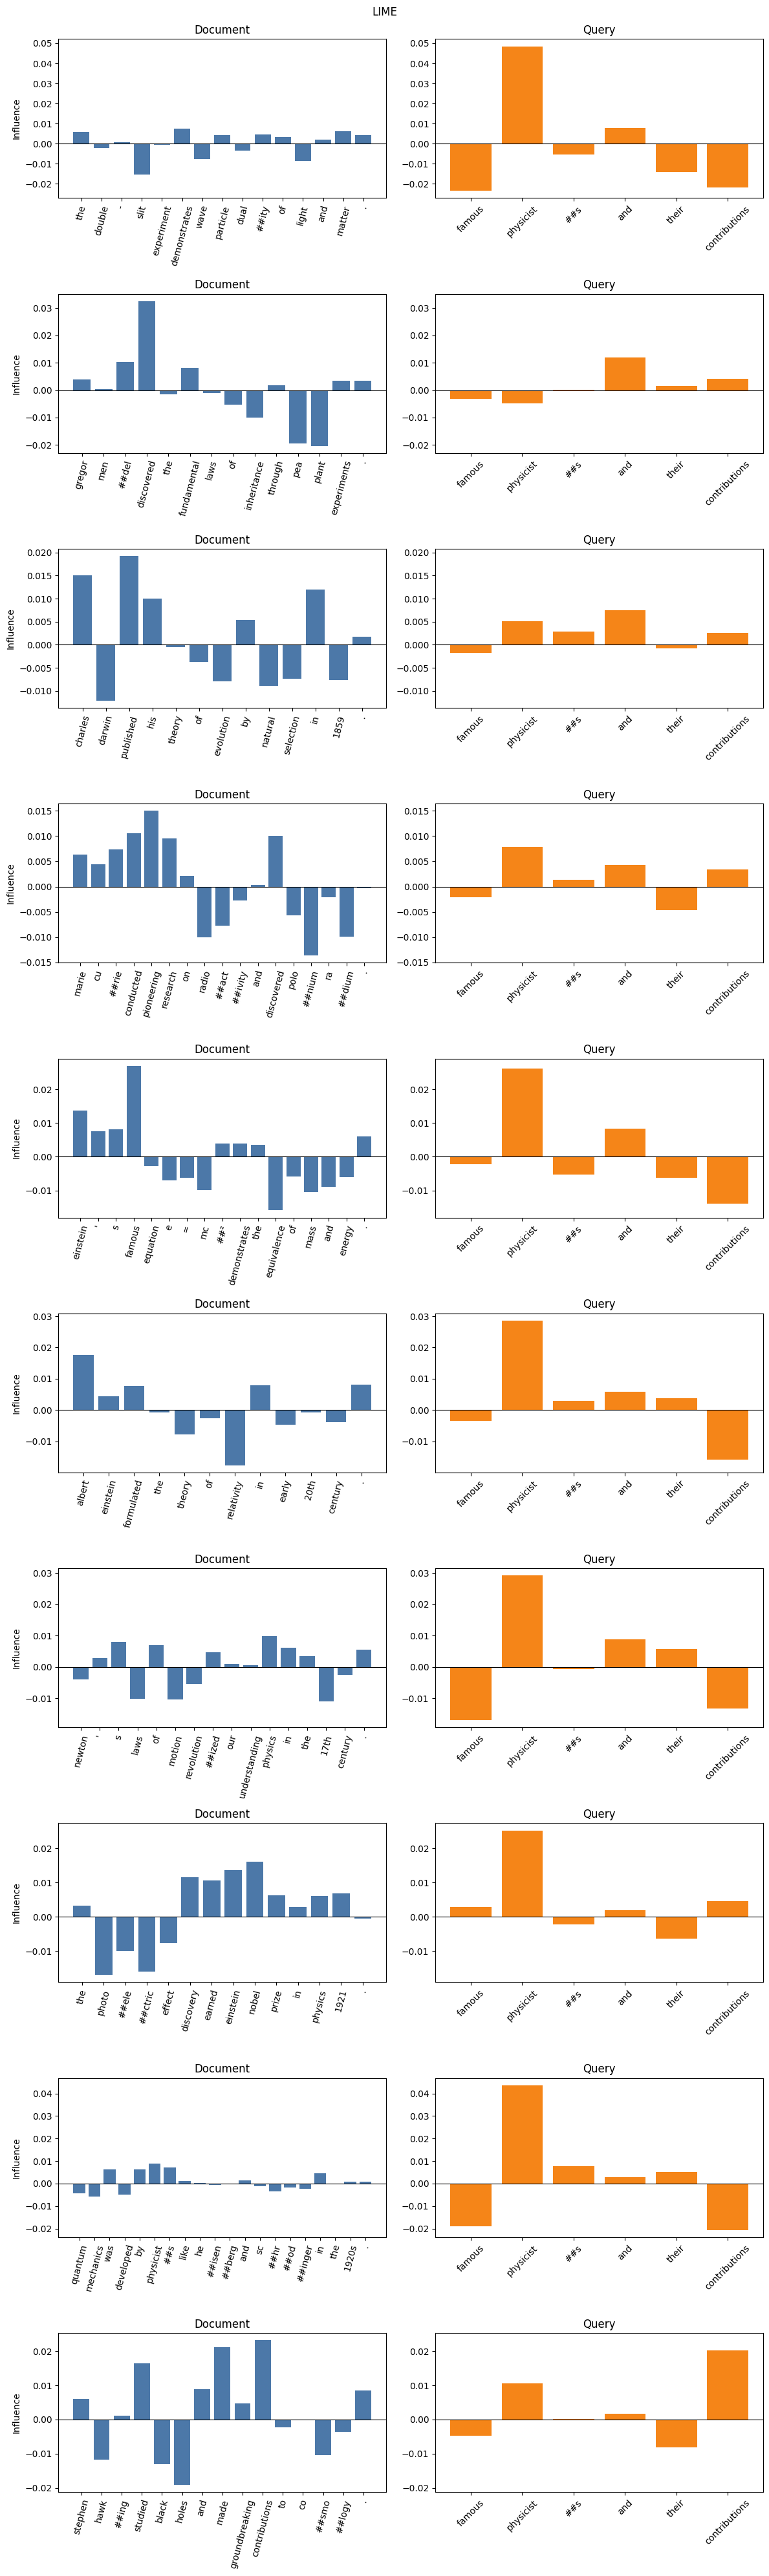

In [20]:
lime_res = [lime(query, res["document"]) for res in results]
figure = plot_influence(lime_res, "LIME")
figure.show()

# Vector Space Investigation

In [21]:
from sklearn.decomposition import PCA

# Labels
phy = model.encode("Physics")
bio = model.encode("Biology")
hist = model.encode("History")
tech = model.encode("Technology")


In [22]:
import umap
import numpy as np

doc_labels = [d["label"] for d in documents]
labels = ["Physics", "Biology", "History", "Technology"]

X = np.vstack([doc_embeddings, phy, bio, hist, tech])
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)
X2 = reducer.fit_transform(X)

doc_X2 = X2[:len(doc_embeddings)]
label_X2 = X2[len(doc_embeddings):]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
import plotly.graph_objects as go


color_map = {
    "Physics": "#1f77b4",
    "Biology": "#2ca02c",
    "History": "#d62728",
    "Technology": "#9467bd",
}
label_colors = [color_map[lbl] for lbl in labels]
point_colors = [color_map[lbl] for lbl in doc_labels]

hover_text_docs = [
    f"Label: {lbl}<br>Text: {txt}" for lbl, txt in zip(doc_labels, [d["text"] for d in documents])
]

doc_trace = go.Scattergl(
    x=doc_X2[:, 0],
    y=doc_X2[:, 1],
    mode="markers",
    marker=dict(color=point_colors, size=7, line=dict(color="white", width=0.5)),
    text=hover_text_docs,
    hovertemplate="%{text}<extra></extra>",
    name="Documents",
)

label_trace = go.Scattergl(
    x=label_X2[:, 0],
    y=label_X2[:, 1],
    mode="markers+text",
    text=labels,
    textposition="middle center",
    textfont=dict(color=label_colors, size=14, family="Arial Black"),
    marker=dict(color=label_colors, size=12, line=dict(color="black", width=1)),
    hovertemplate="Concept vector: %{text}<extra></extra>",
    name="Concepts",
)

fig = go.Figure(data=[doc_trace, label_trace])
fig.update_layout(
    title=f"UMAP: Document to Conecept - {model_id}",
    xaxis_title="UMAP-1",
    yaxis_title="UMAP-2",
    hovermode="closest",
    template="plotly_white",
    legend_title="Ebenen",
)
fig.write_html("umap_concepts.html", include_plotlyjs="cdn")
fig.show()


# Document to Concept Similarity

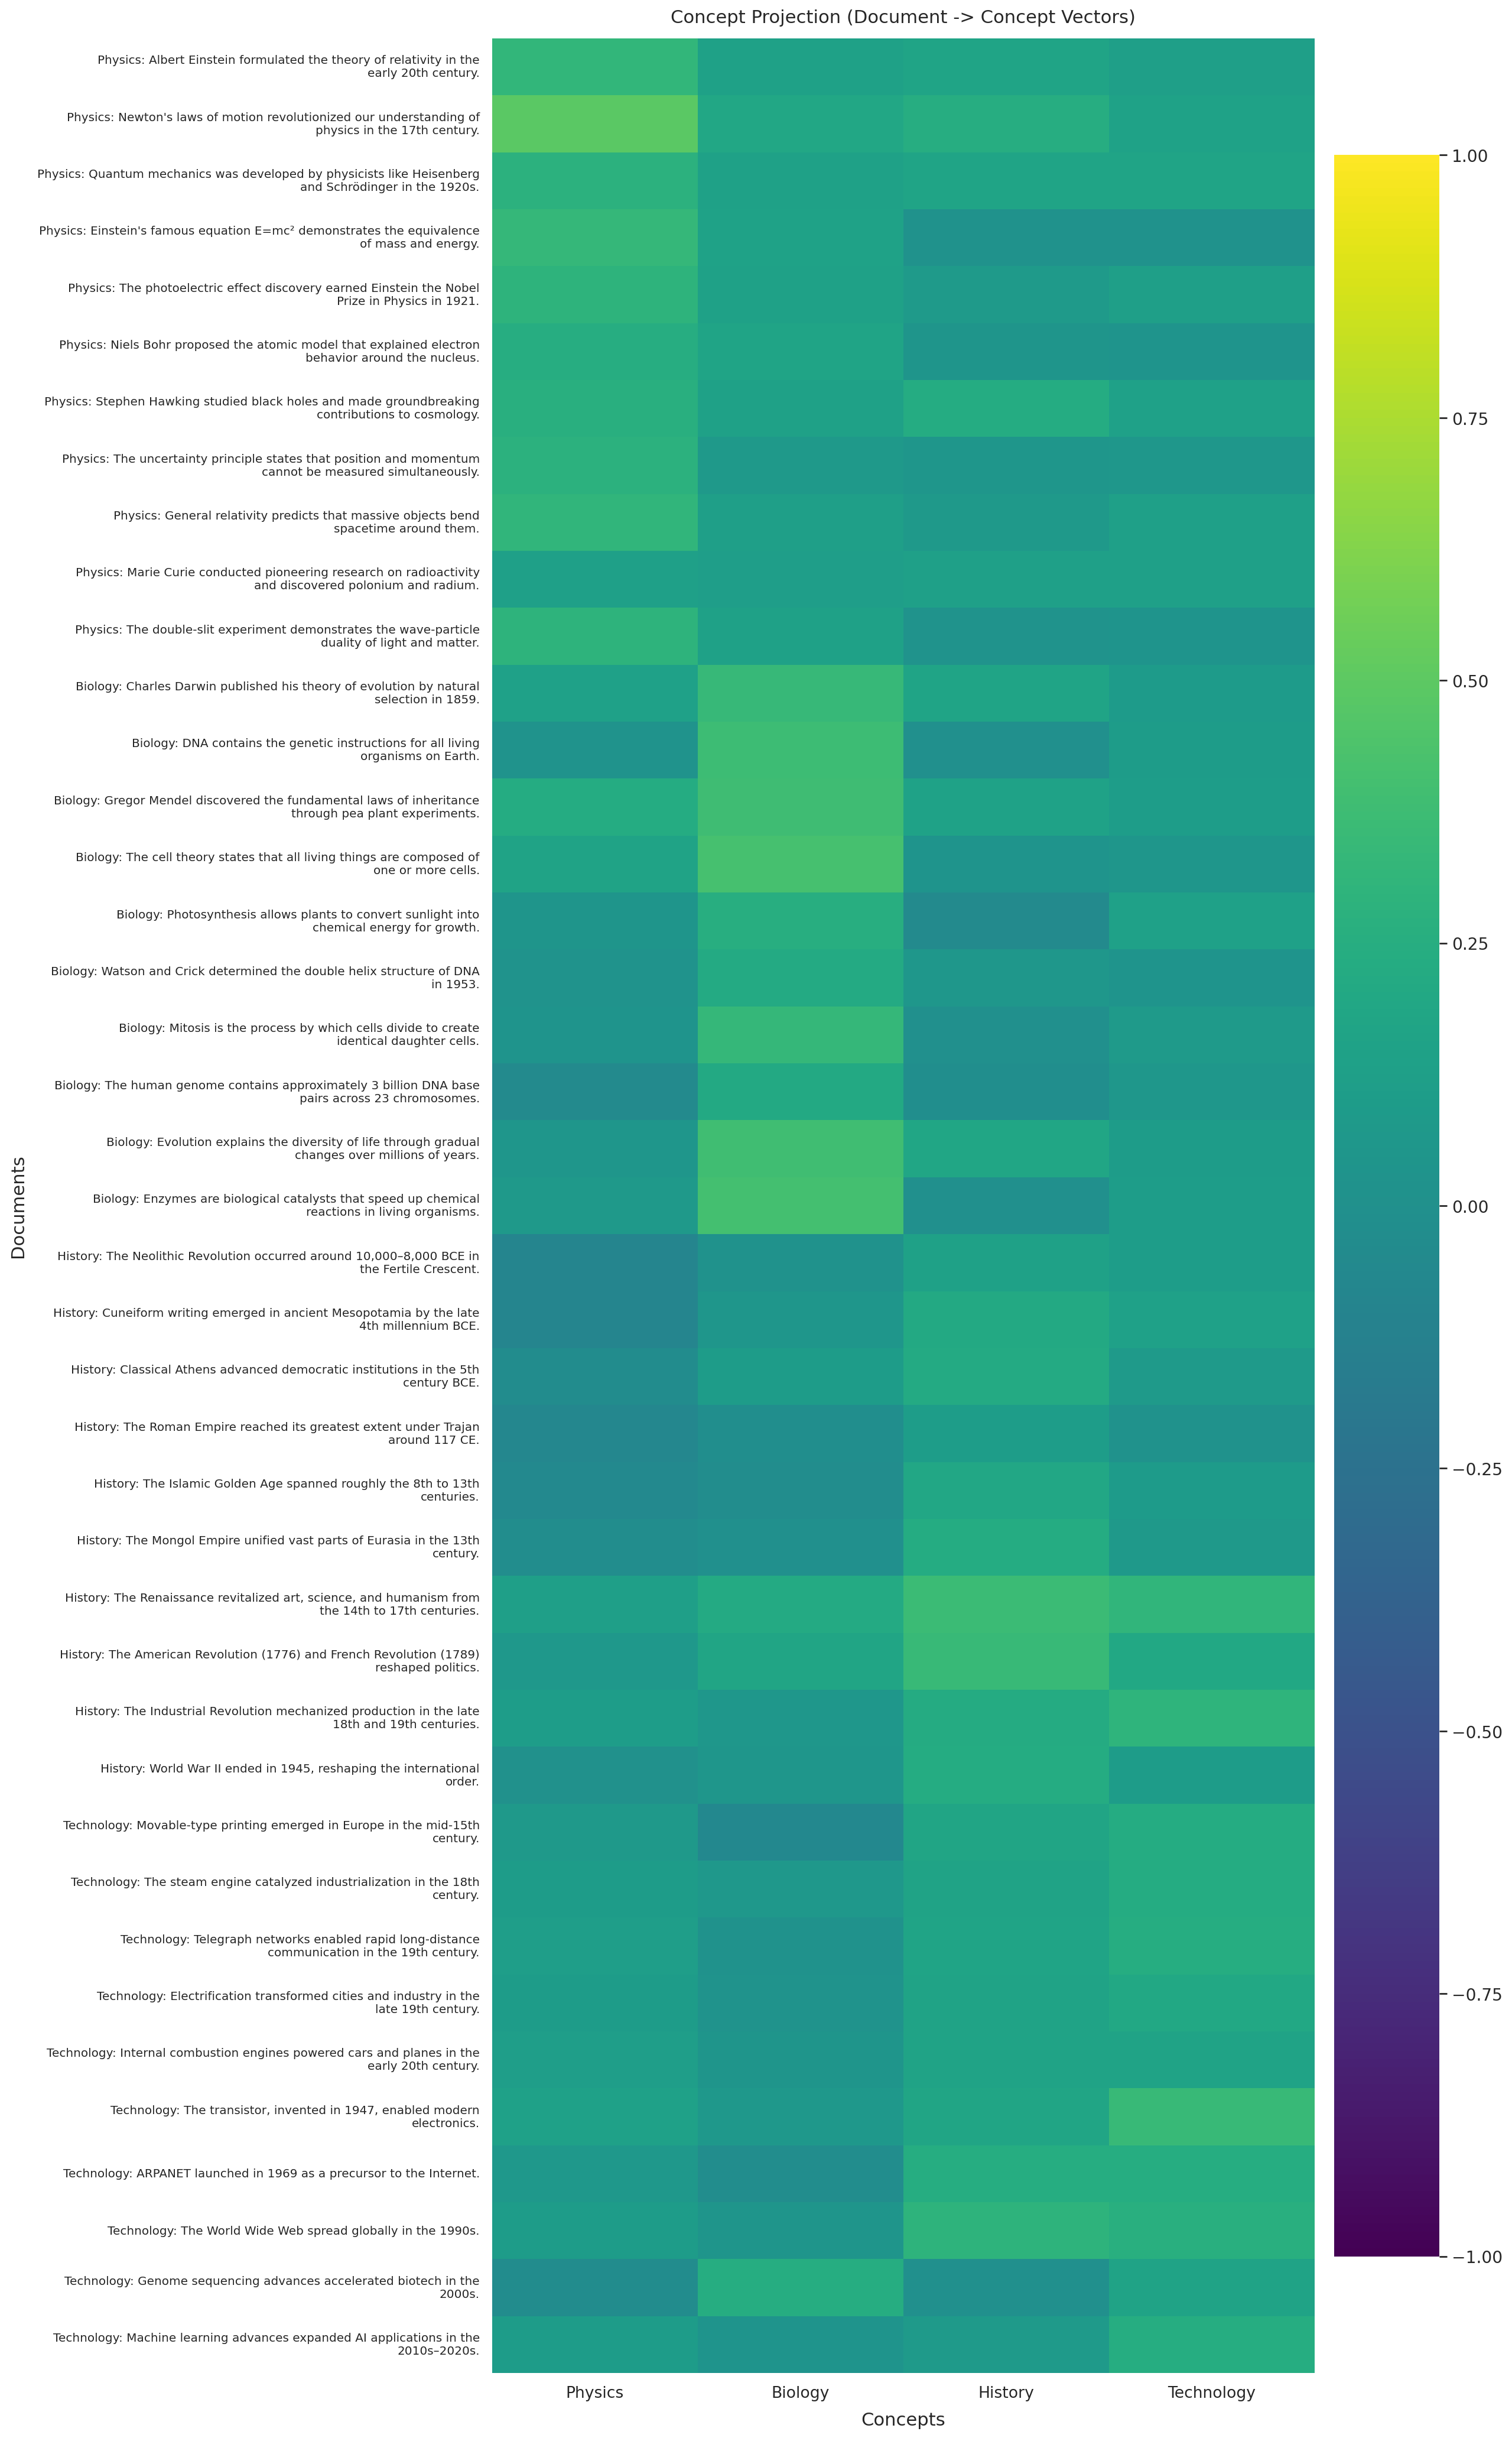

In [24]:
import seaborn as sns
import textwrap


concept_mat = np.vstack([phy, bio, hist, tech])
proj = util.cos_sim(doc_embeddings, concept_mat).detach().cpu().numpy()

ytexts = [textwrap.fill(f"{d['label']}: {d['text']}", width=70) for d in documents]

sns.set(font_scale=1.15)
fig, ax = plt.subplots(figsize=(16, 26), dpi=160)

hm = sns.heatmap(
    proj,
    ax=ax,
    cmap="viridis",
    vmin=-1.0, vmax=1.0,
    xticklabels=labels,
    yticklabels=ytexts,
    annot=False,
    cbar_kws={"shrink": 0.9, "pad": 0.02}
)

ax.set_title("Concept Projection (Document -> Concept Vectors)", pad=12)
ax.set_xlabel("Concepts", labelpad=8)
ax.set_ylabel("Documents", labelpad=8)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=9)

plt.tight_layout()
plt.show()